### Links

* https://wiseodd.github.io/techblog/2016/06/22/nn-optimization/ (Nasterov Momementum)
* https://wiseodd.github.io/techblog/2016/06/21/nn-sgd/ (Implementing Minibatch Gradient Descent)
* https://gitlab.com/erehm/PiecewiseG1BezierFit (MATLAB Fitting a Bezier curve)
* https://github.com/soswow/fit-curve/blob/1bc4dd6fd43e21052a0e706d5de57e801bc35085/python/fitCurves.py (Python implementation of fitCurve)
* 

In [42]:
import _MEWtools as mt
import multiprocessing

## Get baseline time for CPU Intensive Workload

In [43]:
iterations = 5

def slow_worker():
    for i in range(8000):
        square = i**i

    print('Done')

In [45]:
import time

# t0 = time.time()

# for i in range(iterations):
#     slow_worker()

# t1 = time.time()

# total = t1-t0
# display(f'Total Execution Time: {total} seconds')

## Perform same operation with multiprocessing

In [46]:
t0 = time.time()

pool = multiprocessing.Pool(iterations)
for i in range(iterations):
    pool.apply_async(slow_worker)
    
pool.close()
pool.join()

t1 = time.time()

total = t1-t0
display(f'Total Execution Time: {total} seconds')

Done
Done
Done
Done
Done


'Total Execution Time: 2.655855178833008 seconds'

## Load an interior structure from a config file and populate a MEWTools Satellite

In [ ]:
import utils

overrides = {
    'obliquity': 0,
    'obliquityPhase': 0,
    'obliquityPhaseRate': 0,
    'spinRate': 0,
    'nonSynchronusRotationRate': 0,
    'librationAmplitude': 0,
    'librationPhase': 0,
    'librationFrequency': 0
}

sample_sat = utils.import_structure('Sample', overrides)

In [ ]:
structures = utils.list_structures()
structures

In [ ]:
import sympy as sym
import numpy as np

r, θ, φ, t = sym.symbols('r θ φ t', real = True)
sample_sat.tt.subs(t,0).subs(φ,np.pi/4).subs(θ,np.pi/4).expand()
sample_sat.tt.expand()

## Performance comparison of different evaluation methods

In [ ]:
import math

fm = sym.lambdify([t, φ, θ], sample_sat.PC1, modules = ["math", {"cot": math.atan}])
fn = sym.lambdify([t, φ, θ], sample_sat.PC1, modules = ["numpy", {"cot": np.arctan}])

# numpy
t0 = time.time()

for i in range(10000):
    fm(0, np.pi/2, np.pi/2)

t1 = time.time()

total = t1-t0
display(f'Total Execution Time for math lamdify: {total} seconds')

#math
t0 = time.time()

for i in range(10000):
    fn(0, np.pi/2, np.pi/2)

t1 = time.time()

total = t1-t0
display(f'Total Execution Time for numpy lamdify: {total} seconds')



# Expand
t0 = time.time()

for i in range(10000):
     sample_sat.PC1.subs(t, 0).subs(φ,np.pi/2).subs(θ,np.pi/2).expand()

t1 = time.time()

total = t1-t0
display(f'Total Execution Time for expand(): {total} seconds')


print(sample_sat.PC1.subs(t, 0).subs(φ,np.pi/2).subs(θ,np.pi/2).expand())
print(fm(0, np.pi/2, np.pi/2))
print(fn(0, np.pi/2, np.pi/2))

In [ ]:
# ttR = sym.re(sample_sat.tt.subs(t,0).subs(φ,np.pi/4).subs(θ,np.pi/4).expand())
# ppR = sym.re(sample_sat.pp.subs(t,0).subs(φ,np.pi/4).subs(θ,np.pi/4).expand())
# tpR = sym.re(sample_sat.tp.subs(t,0).subs(φ,np.pi/4).subs(θ,np.pi/4).expand())

# import time

# diffs = []
# for i in range(1000):
#     t0 = time.time()

#     val1 = sample_sat.PC1.subs(t,0).subs(φ,np.pi/4).subs(θ,np.pi/4).expand()
#     val2 = sample_sat.PC2.subs(t,0).subs(φ,np.pi/4).subs(θ,np.pi/4).expand()
#     val3 = sample_sat.PCΨ.subs(t,0).subs(φ,np.pi/4).subs(θ,np.pi/4).expand()
#     val4 = sample_sat.PCΨ2.subs(t,0).subs(φ,np.pi/4).subs(θ,np.pi/4).expand()

#     t1 = time.time()

#     total1 = t1-t0
# #     display(f'Total Execution Time: {total1} seconds')

#     import math
#     t0 = time.time()

#     pc1  = (1/2) * (ttR + ppR + math.sqrt(4*tpR**2 + (ttR-ppR)**2))
#     pc2  = (1/2) * (ttR + ppR - math.sqrt(4*tpR**2 + (ttR-ppR)**2))
#     pc3  = (1/2) * math.atan( (2*tpR)/(ttR-ppR))
#     pc4 = (1/2) * math.atan2((2*tpR),(ttR-ppR))

#     t1 = time.time()

#     total2 = t1-t0
# #     display(f'Total Optimized Execution Time: {total2} seconds')
#     diffs.append(total1 - total2)
    
# np.average(diffs)

## Checking degrees to radians performance with constant vs equation

In [ ]:
import time
import numpy as np

ITERATIONS = 1000000

t0 = time.time()

for i in range(ITERATIONS):
    rads = np.radians(60)

t1 = time.time()

total_np = t1-t0
display(f'Rads: {rads}')
display(f'Total Full Execution Time: {total_np} seconds')

# With constant
t0 = time.time()

rad_multiplier = np.pi / 180
for i in range(ITERATIONS):
    rads = 60 * rad_multiplier

t1 = time.time()

total_const = t1-t0
display(f'Rads: {rads}')
display(f'Total Execution Time: {total_const} seconds')

percent_faster = round(((total_np-total_const)/total_np) * 100, 2)
display(f'Using a constant is {percent_faster}% faster than using numpy.radians')

**Theta = Longitude**

**Phi = Latitude**

## Lets try to build a grid

In [ ]:
# import pandas as pd
# import numpy as np
# import math
# import sympy as sym
# import multiprocessing, logging

# logger = multiprocessing.log_to_stderr()
# logger.setLevel(logging.INFO)

# r, θ, φ, t = sym.symbols('r θ φ t', real = True)

# t0 = time.time()

# sat = utils.import_structure('Sample', overrides)

# t1 = time.time()
# total = (t1 - t0)
           
# print(f'Load Structure time: {total}')

# TIME_STEPS = 360
# MIN_LAT = -75
# MAX_LAT = 90
# MIN_LON = 0
# MAX_LON = 360
# RAD_MULTIPLIER = np.pi / 180

# data = []

# principal1_func = sym.lambdify([t, φ, θ], sample_sat.PC1, modules = ["math", {"cot": math.atan}])
# principal2_func = sym.lambdify([t, φ, θ], sample_sat.PC2, modules = ["math", {"cot": math.atan}])
# principal_phi_func = sym.lambdify([t, φ, θ], sample_sat.PCΨ, modules = ["math", {"cot": math.atan}])
# principal_phi2_func = sym.lambdify([t, φ, θ], sample_sat.PCΨ2, modules = ["math", {"cot": math.atan}])


# def callback(stress_items):
#     data.extend(stress_items)
    

# def get_stress_for_lat(step, lat):
#     results = []
# #     lat_radians = lat * RAD_MULTIPLIER
#     lat_radians = np.radians(lat)
#     step_value = step / TIME_STEPS
    
#     logger.info("ABOUT TO PERFORM CALCULATIONS")
    
#     for lon in range(MIN_LON, MAX_LON + 1, 10):
#         if (lat == 90 or lon == 0):
#             continue
            
# #         lon_radians = np.Radians(lon) * RAD_MULTIPLIER
#         lon_radians = np.radians(lon)

#         principal1 = principal1_func(step_value, lat_radians, lon_radians)
# #         principal1 = sat.PC1.subs(t,step_value).subs(φ,lat_radians).subs(θ,lon_radians).expand()

#         principal2 = principal2_func(step, lat_radians, lon_radians)
#         principal_phi = principal_phi_func(step, lat_radians, lon_radians)
#         principal_phi2 = principal_phi2_func(step, lat_radians, lon_radians)        

#         max_stress = max(principal1, principal2)
#         max_stress_orientation = principal_phi if max_stress == principal1 else principal_phi2
  
        
#         results.append({
#                 'time_step': step,
#                 'latitude': lat,
#                 'longitude': lon,
#                 'principal1': principal1,
#                 'principal2': principal2,
#                 'principal_orientation': np.rad2deg(principal_phi),
#                 'principal_orientation2': np.rad2deg(principal_phi2),
#                 'max_stress': max_stress,
#                 'max_stress_orientation': np.rad2deg(max_stress_orientation)
#             })
        
#     return results

    
# pool = multiprocessing.Pool()

# t0 = time.time()

# for step in range(TIME_STEPS):
#     for lat in range(MIN_LAT, MAX_LAT + 1, 15):
#         pool.apply_async(get_stress_for_lat, args = (step, lat, ), callback=callback)
# #         data.extend(get_stress_for_lat(step, lat))
            
# pool.close()
# pool.join()
            
# t1 = time.time()
# total = (t1 - t0)
           
# print(f'Calculation time: {total}')

# df = pd.DataFrame(data)   
# t2 = time.time()
# print(f'DataFrame Creation time: {t2 - t1}')


In [ ]:
# lat = 60
# lon = 250

# print(principal1_func(0, lat * RAD_MULTIPLIER, lon * RAD_MULTIPLIER))
# print(principal2_func(0, lat * RAD_MULTIPLIER, lon * RAD_MULTIPLIER))
# print(principal_phi_func(0, lat * RAD_MULTIPLIER, lon * RAD_MULTIPLIER))
# print(principal_phi2_func(0, lat * RAD_MULTIPLIER, lon * RAD_MULTIPLIER))

In [ ]:
# df.sort_values(['latitude', 'longitude', 'time_step'])

In [47]:
import StressTools as tools
import utils
import time

t0 = time.time()

sat = utils.import_structure('Sample')

t1 = time.time()
total = (t1 - t0)
           
print(f'Load Structure time: {total}')


Load Structure time: 6.293004035949707


In [48]:
t0 = time.time()

europa_orbit_seconds = 85 * 3600
df = tools.build_stress_field(sat, europa_orbit_seconds, rotations=2)

t1 = time.time()
total = (t1 - t0)
           
print(f'Build Stress Field time: {total}')

Build Stress Field time: 2.320572853088379


In [ ]:
data = df.loc[(df['latitude'] == 45) & (df['longitude'] == 60)] \
    .sort_values('time_step')

import matplotlib.pyplot as plt

plt.plot(data['time_step'], data['principal1'])
data

In [49]:
import numpy as np
import legacy.StressEQs as stress1
import StressEquations as stress2

In [50]:
result1 = stress1.getStress(
    interior=1, 
    e_in=0.01, 
    colat=np.radians(45), 
    lon=np.radians(60), 
    steps=360, 
    this_step=5,
    oblq=0.1,
    phase=0.1,
    NSRdelta=42
)
print(result1)

result2 = stress2.getStress(
    interior_value='interior1', 
    e_in=0.01, 
    colat=np.radians(45), 
    lon=np.radians(60), 
    steps=360, 
    this_step=5,
    oblq=0.1,
    phase=0.1,
    NSRdelta=42
)
print(result2)

abs(np.array(result1) - np.array(result2))

(71.8810108076292, 3.2669857015654484)
(71.88101084929254, 3.2669857043257293)


array([4.16633412e-08, 2.76028089e-09])

In [51]:
import utils

value = utils.import_interior('interior1')
display(value)

In [ ]:
value.modal_strengths

In [ ]:
import numpy as np

points = [
    (1, 1),
    (2, 3),
    (4, 5),
    (6, 7),
    (8, 8),
    (11, 6),
    (12, 4),
    (12, 1)
]
points = np.array(points)

In [ ]:
import curves.fitCurves as fit

result = fit.fitCurve(points, 1)
result

In [ ]:
x = [point[0] for point in points]
y = [point[1] for point in points]

x2 = [point[0] for point in result[0]]
y2 = [point[1] for point in result[0]]

import matplotlib.pyplot as plt
plt.scatter(x, y)
plt.scatter(x2, y2)

### Cubic Bezier Equation

$$B'(t) = (1 - t)^3P_0 + 3(1 - t)^2tP_1 + 3(1-t)t^2P_2 + t^3P_3, 0 \le t \le 1$$

In [ ]:
import numpy as np
import curves.bezier as bezier
import StressEquations as stress
import utils

curve = result[0]

bpoints = []
for t in np.arange(0, 1, 0.01):
    point = bezier.q(result[0], t)
    bpoints.append(point)
    
x = [point[0] for point in bpoints]
y = [point[1] for point in bpoints]

x2 = [point[0] for point in result[0]]
y2 = [point[1] for point in result[0]]

x3 = [point[0] for point in points]
y3 = [point[1] for point in points]

import matplotlib.pyplot as plt
plt.plot(x, y)
plt.scatter(x2, y2)
plt.scatter(x3, y3)

for time in np.arange(0.15, 1, 0.2):
    direction = bezier.findCubicRPoints(curve, time)
    dirX = [point[0] for point in direction]
    dirY = [point[1] for point in direction]
    plt.plot(dirX, dirY)


## Observed Cycloids

In [ ]:
import pandas as pd

df = pd.read_csv("./obsData/AlexLonLatCut.txt", header=None, sep=' ', names=['lon', 'lat'])
df

In [ ]:
firstArc = df[0:26]

def translate(point):
    return (point[0], point[1] + 70)
    
points = np.array(firstArc)
points = np.array(list(map(translate, points)))

controls = fit.fitCurve(points, 0.05)


plt.xlim(17.7, 10)
# plt.ylim(15, 18)

plt.scatter(firstArc['lon'], firstArc['lat'] + 70)
# plt.scatter(x, y)

bpoints = []

for control in controls:
    for t in np.arange(0, 1, 0.01):
        point = bezier.q(control, t)
        bpoints.append(point)
    
    x = [point[0] for point in bpoints]
    y = [point[1] for point in bpoints]
    plt.plot(x, y)
    
    for time in np.arange(0.15, 1, 0.02):
        direction = bezier.findCubicRPoints(control, time)
        dirX = [point[0] for point in direction]
        dirY = [point[1] for point in direction]
        plt.plot(dirX, dirY)

In [ ]:
points = np.array(firstArc)

controls2 = fit.fitCurve(points, 0.05)


plt.xlim(17.7, 10)
# plt.ylim(15, 18)

plt.scatter(firstArc['lon'], firstArc['lat'])
# plt.scatter(x, y)

bpoints = []

for control in controls2:
    for t in np.arange(0, 1, 0.01):
        point = bezier.q(control, t)
        bpoints.append(point)
    
    x = [point[0] for point in bpoints]
    y = [point[1] for point in bpoints]
    plt.plot(x, y)
    
    for time in np.arange(0.15, 1, 0.02):
        direction = bezier.findCubicRPoints(control, time)
        dirX = [point[0] for point in direction]
        dirY = [point[1] for point in direction]
        plt.plot(dirX, dirY)

In [ ]:
points

In [ ]:
controls

# Try fitting Delphi

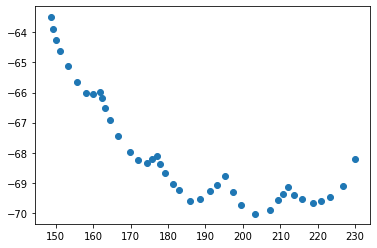

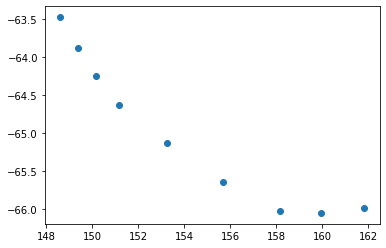

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import curves.bezier as bezier
import curves.fitCurves as fit
import curves.fitArcs as fitArcs
import StressTools as tools

def round_heading(value, base=5):
    return base * round(value / base)

def calculate_loss(frame):
    diffs = np.diff(frame.sort_values('pointNumber')['pointNumber'])
    
    edges = frame.iloc[[0, -1]]
    startDiff = edges.iloc[0].pointNumber - 1
    endDiff = 100 - edges.iloc[1].pointNumber
    
    diffs = np.append(diffs, [startDiff, endDiff])
    return max(diffs)

TOLERANCE = 1

delphi = pd.read_csv("./obsData/DelphiLonLatAT.txt", header=None, sep=' ', names=['lon', 'lat'])
delphi = delphi.sort_values(['lon', 'lat'])

plt.scatter(delphi['lon'], delphi['lat'])

plt.figure()

plt.scatter(firstArc['lon'], firstArc['lat'])


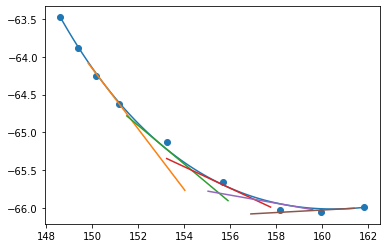

In [58]:
points = np.array(firstArc)

controls = fit.fitCurve(points, 0.05)

# plt.xlim(17.7, 10)
# plt.ylim(15, 18)

def findHeading(points, reverse = False):
    if reverse:
        origin = 1
        destination = 0
    else:
        origin = 0
        destination = 1
        
    rise = points[destination][1] - points[origin][1] # lats
    run = points[destination][0] - points[origin][0]  # lons
    
    degrees = np.degrees(np.arctan2(run, rise))
    if degrees < 0:
        degrees += 360
    return degrees if degrees > 180 else degrees + 180

bpoints = []
rows = []

plt.scatter(firstArc['lon'], firstArc['lat'])

pointNumber = 1
for control in controls:
    for t in np.arange(0, 1, 0.01):
        point = bezier.q(control, t)
        bpoints.append(point)
    
        heading = findHeading(bezier.findCubicRPoints(control, t), False)
        heading_reverse = findHeading(bezier.findCubicRPoints(control, t), True)
        rowData = {
            'pointNumber': pointNumber,
            'lon': point[0],
            'lat': point[1],
            'heading': heading,
            'headingCategory': round_heading(heading, TOLERANCE),
            'headingReverse': heading_reverse,
            'headingCategoryReverse': round_heading(heading_reverse, TOLERANCE)
        }
        rows.append(rowData)
        pointNumber += 1
        
    x = [point[0] for point in bpoints]
    y = [point[1] for point in bpoints]
    plt.plot(x, y)
    
    for time in np.arange(0.15, 1, 0.2):
        direction = bezier.findCubicRPoints(control, time)
        dirX = [point[0] for point in direction]
        dirY = [point[1] for point in direction]
        plt.plot(dirX, dirY)
        
df = pd.DataFrame(rows)
# df

In [59]:
def fit_arc(arc, max_error=0.05, reverse=False):
    points = np.array(arc)
    controls = fit.fitCurve(points, max_error)
    
    if reverse:
        controls = controls[::-1]
    
    rows = []
    pointNumber = 1
    for control in controls:
        if reverse:
            control.reverse()
        for time in np.arange(0, 1, 0.01):
            point = bezier.q(control, time)

            heading = findHeading(bezier.findCubicRPoints(control, time))
            rows.append({
                'pointNumber': pointNumber,
                'lon': point[0],
                'lat': point[1],
                'heading': heading,
                'headingCategory': round_heading(heading, TOLERANCE)
            })
            pointNumber += 1
                
    return pd.DataFrame(rows)

### Generate stress field based on our list of coordinates

In [60]:
import StressEquations as stress
import utils

interior = utils.import_interior('interior1')

stresses = []


for point in df.itertuples():
    for step in range(360):
        current = stress.getStress(
            interior_value=interior, 
            e_in=0.01, 
            colat=np.radians(90-point.lat), 
            lon=np.radians(360-point.lon), 
            steps=360, 
            this_step=step,
            oblq=0.25,
            phase=90,
            NSRdelta=0)
        heading_degrees = np.degrees(current[1])
        stresses.append({
            'lon': point.lon,
            'lat': point.lat,
            'stress': current[0],
            'heading': heading_degrees,
            'headingCategory': round_heading(heading_degrees, TOLERANCE),
            'time': step
        })
        
stressFrame = pd.DataFrame(stresses)


In [61]:
def build_stress_field(interior, pointFrame, phase):
    for point in pointFrame.itertuples():
        for step in range(360):
            current = stress.getStress(
                interior_value=interior, 
                e_in=0.01, 
                colat=np.radians(90-point.lat), 
                lon=np.radians(360-point.lon), 
                steps=360, 
                this_step=step,
                oblq=0.25,
                phase=np.radians(phase),
                NSRdelta=0)
            heading_degrees = np.degrees(current[1])
            stresses.append({
                'lon': point.lon,
                'lat': point.lat,
                'stress': current[0],
                'heading': heading_degrees,
                'headingCategory': round_heading(heading_degrees, TOLERANCE),
                'time': step
            })

    return pd.DataFrame(stresses)

### Search for matches in headings between curve and stress field

In [5]:
# Forward propagation

merged = df.merge(
    stressFrame,
    how='left',
    on=['lon', 'lat', 'headingCategory']
)

In [46]:
# merged.loc[not df.isnull(merged['stress'])]
merged = merged.loc[merged['stress'] > 0]
merged['maxStress'] = merged.groupby('pointNumber')['stress'].transform('max')
merged_unique = merged.loc[merged['stress'] == merged['maxStress']]

calculate_loss(merged_unique)

31.0

In [62]:
def match_orientations(curve, stresses):
    merged = curve.merge(
        stresses,
        how='left',
        on=['lon', 'lat', 'headingCategory']
    )
    merged = merged.loc[merged['stress'] > 0]
    merged['maxStress'] = merged.groupby('pointNumber')['stress'].transform('max')
    merged_unique = merged.loc[merged['stress'] == merged['maxStress']]
    
    return merged_unique

In [10]:
# Reverse propagation

# merged = df.merge(
#     stressFrame,
#     how='left',
#     left_on=['lon', 'lat', 'headingCategoryReverse'],
#     right_on=['lon', 'lat', 'headingCategory']
# )

# print(len(merged))
# merged.loc[merged['stress'] > 0]

# # merged.groupby(['lon', 'lat']).size()
# # merged = merged.loc[merged['stress'] > 0]
# merged['maxStress'] = merged.groupby(['lon', 'lat'])['stress'].transform('max')

# merged_unique = merged.loc[merged['stress'] == merged['maxStress']]
# display(merged_unique)
# display(merged)


In [63]:
plt.scatter(merged_unique['lon'], merged_unique['lat'], alpha=0.3, color='green')

positive = merged_unique.loc[merged_unique['stress'] > 0]
plt.scatter(positive['lon'], positive['lat'], alpha=0.3, color='red')

x = [point[0] for point in bpoints]
y = [point[1] for point in bpoints]
plt.plot(x, y)

NameError: name 'merged_unique' is not defined

### Brute force search phases

In [24]:
results = []

for phase in range(0, 360, 20):
    field = build_stress_field(interior, df, phase)
    matches = match_orientations(df, field)
    loss = calculate_loss(matches)
    
    results.append({
        'phase': phase,
        'error': loss
    })
    print(f'Calculated for phase {phase}')
    
results = pd.DataFrame(results)
results

Calculated for phase 0
Calculated for phase 20
Calculated for phase 40
Calculated for phase 60
Calculated for phase 80
Calculated for phase 100
Calculated for phase 120
Calculated for phase 140
Calculated for phase 160
Calculated for phase 180
Calculated for phase 200
Calculated for phase 220
Calculated for phase 240
Calculated for phase 260
Calculated for phase 280
Calculated for phase 300
Calculated for phase 320
Calculated for phase 340


,phase,error
0,0,9.0
1,20,9.0
2,40,9.0
3,60,9.0
4,80,9.0
5,100,9.0
6,120,9.0
7,140,9.0
8,160,9.0
9,180,9.0


In [64]:
def test_arc(arc, phase_increment):
    results = []

    for phase in range(0, 361, phase_increment):
        field = build_stress_field(interior, arc, phase)
        matches = match_orientations(arc, field)
        loss = calculate_loss(matches)

        results.append({
            'phase': phase,
            'error': loss
        })
        print(f'Calculated for phase {phase}')

    return pd.DataFrame(results) 
    

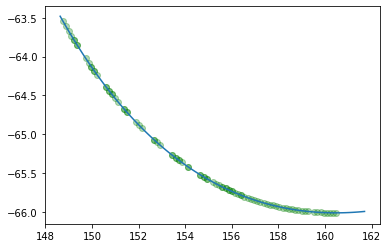

In [19]:
field = build_stress_field(interior, df, 300)
matches = match_orientations(df, field)

plt.scatter(matches['lon'], matches['lat'], alpha=0.3, color='green')

x = [point[0] for point in bpoints]
y = [point[1] for point in bpoints]
plt.plot(x, y)

(array([ 9., 10.,  7., 11., 10., 13., 16.,  7.,  7.,  6.]),
 array([  1.45946412,  14.84710344,  28.23474275,  41.62238207,
         55.01002139,  68.39766071,  81.78530003,  95.17293934,
        108.56057866, 121.94821798, 135.3358573 ]),
 <a list of 10 Patch objects>)

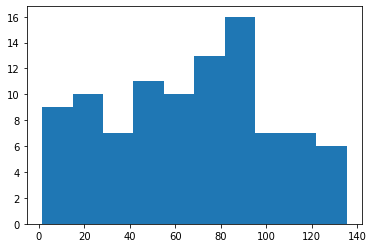

In [58]:
plt.hist(matches['stress'])

<BarContainer object of 96 artists>

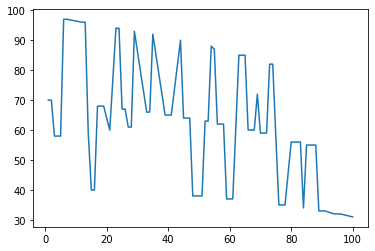

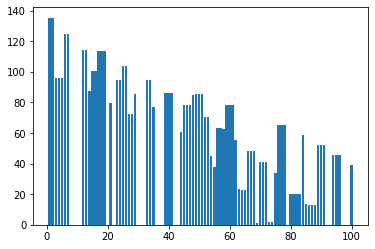

In [63]:
plt.plot(matches['pointNumber'], matches['time'])
plt.figure()
plt.bar(matches['pointNumber'], matches['stress'])

### Experiment: Reversing the control points in a Bezier results in the same exact curve

[array([148.63, -63.48]),
 array([152.61262959, -65.62852386]),
 array([157.3777131 , -66.13134244]),
 array([161.83, -65.99])]

[array([161.83, -65.99]),
 array([157.3777131 , -66.13134244]),
 array([152.61262959, -65.62852386]),
 array([148.63, -63.48])]

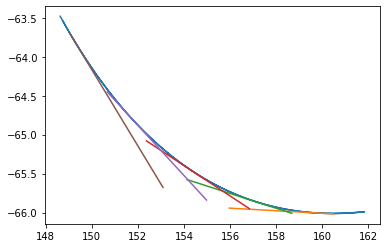

In [64]:
control_rev = control[::-1]
display(control)
display(control_rev)

for control in controls[::-1]:
    control.reverse()
    for t in np.arange(0, 1, 0.01):
        point = bezier.q(control, t)
        bpoints.append(point)
    
    x = [point[0] for point in bpoints]
    y = [point[1] for point in bpoints]
    plt.plot(x, y)
    
    for time in np.arange(0.15, 1, 0.2):
        direction = bezier.findCubicRPoints(control, time)
        dirX = [point[0] for point in direction]
        dirY = [point[1] for point in direction]
        plt.plot(dirX, dirY)

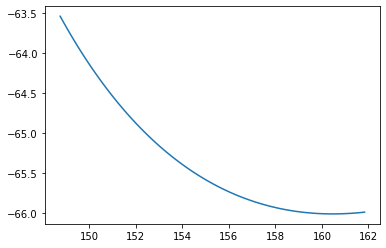

In [72]:
controls = fit.fitCurve(points, 0.05)

bpoints = []
rows = []

pointNumber = 1
for control in controls[::-1]:
    control.reverse()

    for t in np.arange(0, 1, 0.01):
        point = bezier.q(control, t)
        bpoints.append(point)
    
        heading = findHeading(bezier.findCubicRPoints(control, t), False)
        heading_reverse = findHeading(bezier.findCubicRPoints(control, t), True)
        rowData = {
            'pointNumber': pointNumber,
            'lon': point[0],
            'lat': point[1],
            'heading': heading,
            'headingCategory': round_heading(heading, TOLERANCE),
            'headingReverse': heading_reverse,
            'headingCategoryReverse': round_heading(heading_reverse, TOLERANCE)
        }
        rows.append(rowData)
        pointNumber += 1
        
    x = [point[0] for point in bpoints]
    y = [point[1] for point in bpoints]
    plt.plot(x, y)
        
df_reverse = pd.DataFrame(rows)

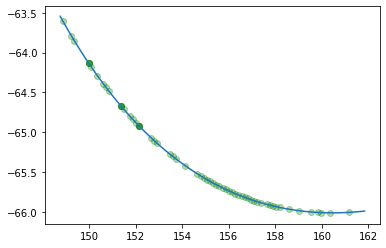

In [73]:
field = build_stress_field(interior, df_reverse, 300)
matches = match_orientations(df_reverse, field)

plt.scatter(matches['lon'], matches['lat'], alpha=0.3, color='green')

x = [point[0] for point in bpoints]
y = [point[1] for point in bpoints]
plt.plot(x, y)

<BarContainer object of 64 artists>

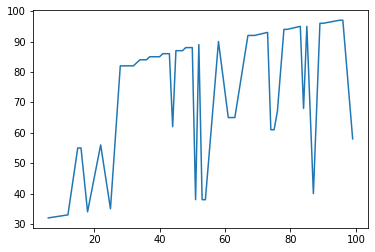

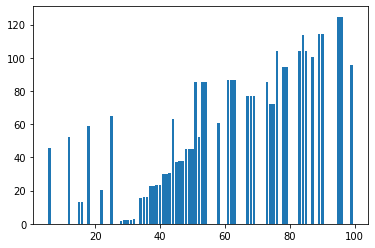

In [74]:
plt.plot(matches['pointNumber'], matches['time'])
plt.figure()
plt.bar(matches['pointNumber'], matches['stress'])

In [75]:
display(df)
display(df_reverse)

,pointNumber,lon,lat,heading,headingCategory,headingReverse,headingCategoryReverse
0,1,148.630000,-63.480000,298.345694,298.0,298.345694,298.0
1,2,148.749713,-63.543963,297.886436,298.0,297.886436,298.0
2,3,148.869888,-63.606945,297.430383,297.0,297.430383,297.0
3,4,148.990520,-63.668951,296.977563,297.0,296.977563,297.0
4,5,149.111601,-63.729988,296.528006,297.0,296.528006,297.0
...,...,...,...,...,...,...,...
95,96,161.159948,-66.006245,269.048457,269.0,269.048457,269.0
96,97,161.294294,-66.003805,268.870925,269.0,268.870925,269.0
97,98,161.428479,-66.000955,268.695499,269.0,268.695499,269.0
98,99,161.562496,-65.997700,268.522162,269.0,268.522162,269.0


,pointNumber,lon,lat,heading,headingCategory,headingReverse,headingCategoryReverse
0,1,161.830000,-65.990000,268.181697,268.0,268.181697,268.0
1,2,161.696339,-65.994046,268.350900,268.0,268.350900,268.0
2,3,161.562496,-65.997700,268.522162,269.0,268.522162,269.0
3,4,161.428479,-66.000955,268.695499,269.0,268.695499,269.0
4,5,161.294294,-66.003805,268.870925,269.0,268.870925,269.0
...,...,...,...,...,...,...,...
95,96,149.233126,-63.790061,296.081739,296.0,296.081739,296.0
96,97,149.111601,-63.729988,296.528006,297.0,296.528006,297.0
97,98,148.990520,-63.668951,296.977563,297.0,296.977563,297.0
98,99,148.869888,-63.606945,297.430383,297.0,297.430383,297.0


In [71]:
controls

[[array([148.63, -63.48]),
  array([152.61262959, -65.62852386]),
  array([157.3777131 , -66.13134244]),
  array([161.83, -65.99])]]

## Lets try to do the entire cycloid

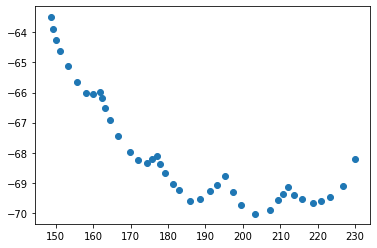

In [65]:
plt.scatter(delphi['lon'], delphi['lat'])

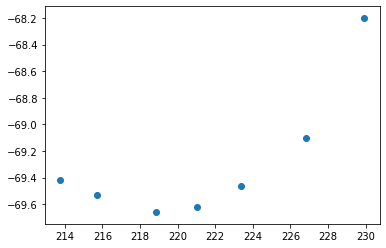

In [66]:
temp = delphi[34:]

plt.scatter(temp['lon'], temp['lat'])

In [67]:
arcs = [
    delphi[0:9],
    delphi[9:18],
    delphi[18:27],
    delphi[27:34],
    delphi[34:]
]

In [72]:
all_curves = None
all_arcs = None

for arc in arcs:
    curve = fit_arc(arc)
    all_curves = curve if all_curves is None else pd.concat([all_curves, curve], ignore_index=True)
    field = build_stress_field(interior, curve, 300)
        
    matches = match_orientations(curve, field)
    all_arcs = matches if all_arcs is None else pd.concat([all_arcs, matches], ignore_index=True)
    print("Finished an arc...")


Finished an arc...
Finished an arc...
Finished an arc...
Finished an arc...
Finished an arc...


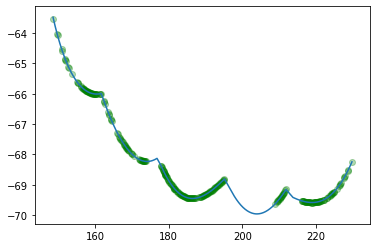

In [73]:
plt.plot(all_curves['lon'], all_curves['lat'])
# plt.scatter(delphi['lon'], delphi['lat'])
plt.scatter(all_arcs['lon'], all_arcs['lat'], alpha=0.3, color='green')

In [71]:
curve = fit_arc(arcs[2])
results = test_arc(curve, 10)
display(results)

Calculated for phase 0
Calculated for phase 10
Calculated for phase 20
Calculated for phase 30
Calculated for phase 40
Calculated for phase 50
Calculated for phase 60
Calculated for phase 70
Calculated for phase 80
Calculated for phase 90
Calculated for phase 100
Calculated for phase 110
Calculated for phase 120
Calculated for phase 130
Calculated for phase 140
Calculated for phase 150
Calculated for phase 160
Calculated for phase 170
Calculated for phase 180
Calculated for phase 190
Calculated for phase 200
Calculated for phase 210
Calculated for phase 220
Calculated for phase 230
Calculated for phase 240
Calculated for phase 250
Calculated for phase 260
Calculated for phase 270
Calculated for phase 280
Calculated for phase 290
Calculated for phase 300
Calculated for phase 310
Calculated for phase 320
Calculated for phase 330
Calculated for phase 340
Calculated for phase 350
Calculated for phase 360


,phase,error
0,0,56.0
1,10,45.0
2,20,13.0
3,30,8.0
4,40,8.0
5,50,8.0
6,60,8.0
7,70,8.0
8,80,8.0
9,90,8.0


# TODO: Add diffs to stress field frame to determine increase or decrease
# TODO: Allow heading match tolerance < 1 degree


In [74]:
all_arcs

,pointNumber,lon,lat,heading_x,headingCategory,stress,heading_y,time,maxStress
0,2,148.749713,-63.543963,297.886436,298.0,132.472097,297.532406,69.0,132.472097
1,10,149.723525,-64.020841,294.330025,294.0,121.197096,293.588114,68.0,121.197096
2,11,149.847167,-64.076188,293.900534,294.0,121.197954,293.664491,68.0,121.197954
3,20,150.977326,-64.533298,290.189759,290.0,111.002725,290.277362,67.0,111.002725
4,21,151.104710,-64.579642,289.794762,290.0,111.018365,290.381566,67.0,111.018365
...,...,...,...,...,...,...,...,...,...
268,87,227.677066,-68.761532,258.023047,258.0,81.491614,258.386525,241.0,81.491614
269,88,227.837606,-68.727064,257.741971,258.0,41.803118,258.352876,207.0,41.803118
270,93,228.641089,-68.542007,256.313399,256.0,47.904788,256.163069,206.0,47.904788
271,94,228.801959,-68.502400,256.023348,256.0,48.063940,256.334907,206.0,48.063940


## Let's do this cleaner

In [1]:
import pandas as pd
# import matplotlib.pyplot as plt
import numpy as np
import curves.bezier as bezier
import curves.fitCurves as fit
import curves.fitArcs as fitArcs
import StressTools as tools
import utils


def calculate_loss(frame):
    diffs = np.diff(frame.sort_values('pointNumber')['pointNumber'])
    
    edges = frame.iloc[[0, -1]]
    startDiff = edges.iloc[0].pointNumber - 1
    endDiff = 100 - edges.iloc[1].pointNumber
    
    diffs = np.append(diffs, [startDiff, endDiff])
    return max(diffs)

interior = utils.import_interior('interior1')

TOLERANCE = 1

delphi = pd.read_csv("./obsData/DelphiLonLatAT.txt", header=None, sep=' ', names=['lon', 'lat'])
delphi = delphi.sort_values(['lon', 'lat'])

# plt.scatter(delphi['lon'], delphi['lat'])

arcs = [
    delphi[0:9],
    delphi[9:18],
    delphi[18:27],
    delphi[27:34],
    delphi[34:]
]

In [2]:
def match_orientations(curve, stresses):
    merged = curve.merge(
        stresses,
        how='left',
        on=['lon', 'lat', 'headingCategory']
    )
    merged = merged.loc[merged['stress'] > 0]
    merged['maxStress'] = merged.groupby('pointNumber')['stress'].transform('max')
    merged_unique = merged.loc[merged['stress'] == merged['maxStress']]
    
    return merged_unique

In [5]:
all_curves = None
all_arcs = None

for arc in arcs:
    curve = fitArcs.fit_arc(arc)
    all_curves = curve if all_curves is None else pd.concat([all_curves, curve], ignore_index=True)
    field = tools.build_simon_stress_field(interior, curve, 300, is_async=False)
        
    matches = match_orientations(curve, field)
    all_arcs = matches if all_arcs is None else pd.concat([all_arcs, matches], ignore_index=True)
    print("Finished an arc...")
    

Finished an arc...
Finished an arc...
Finished an arc...
Finished an arc...
Finished an arc...


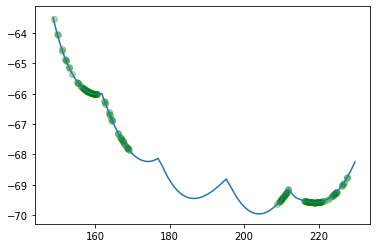

In [6]:
import matplotlib.pyplot as plt

plt.plot(all_curves['lon'], all_curves['lat'])
plt.scatter(all_arcs['lon'], all_arcs['lat'], alpha=0.3, color='green')

# conda environments:
#
base                  *  /Users/stan/Applications/Anaconda/anaconda3
europa_cycloids          /Users/stan/Applications/Anaconda/anaconda3/envs/europa_cycloids
plaidml                  /Users/stan/Applications/Anaconda/anaconda3/envs/plaidml
torch                    /Users/stan/Applications/Anaconda/anaconda3/envs/torch

